# Q 2

1) The code of your final solution. Jupyter notebook is preferred.

Please see bellow

2) The results of the exploration phase as well as the prediction on your test set, and your evaluation. Please describe special considerations and challenges.

A. We are going to predict a probability of click, so lets choose the cross entropy as the metric.

B. There are too many coupons and too many users for my small laptop. So I can't use them as a categorical variables, and need a way to embed them to lower dimension. So, the idea is to encode users, coupons and users $\times$ coupons using their performance (something like target encoding). The information how many times user already saw this coupon and how many times he bought it, also can be useful. The same about any coupon and about any  user. It will nice to define a similarity metric for users/coupons based on common coupon they was consumed, but I have neither time for this, nor resources (computaitional). 


3) How would you use your model to select the top 5 coupons to maximize the revenue from coupon consumption? The revenue from a coupon is the value of

Since we predict a probability, one can compute the expectation by multiplication of the probability by coupons value. 

4) Suppose the dataset contains a combination of new and relatively old coupons. How will you handle the coupon consumption for new coupons? How will you combine the selection of new and relatively old coupons? 

Sounds like exploration/exploitation problem. We can define a parameter $\epsilon$ and make some random decision with probability $\epsilon$ . Another option, to show coupons randomly, with probability proportional to creadability interval. 

In [1]:
#
# import packages
#

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

/home/boris/.virtualenvs/jupyter/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
#
# load data, replace all strings by numbers.
# it should save a space, improve readability and to speedup code
#

data_columns=['PURCHASE_FLG','I_DATE','VIEW_COUPON_ID_hash','USER_ID_hash','SESSION_ID_hash']

coupons = pd.read_csv('data/coupon_list_rj.csv')
users   = pd.read_csv('data/user_list_rj.csv')
data    = pd.read_csv('data/coupon_visit_train_rj.csv', parse_dates=['I_DATE'], usecols=data_columns)

df = data.set_index('USER_ID_hash') \
         .join(users.set_index('USER_ID_hash'), how='inner') \
         .reset_index().set_index('VIEW_COUPON_ID_hash') \
         .join(coupons.set_index('COUPON_ID_hash'), how='inner') \
         .reset_index()

df.rename(columns={'index': 'COUPON', 'USER_ID_hash': 'USER', 'PURCHASE_FLG': 'FLG', 'SESSION_ID_hash': 'SESSION'}, inplace=True)
    
strings_packed = False

In [3]:
def pack_to_enum_inplace(df, column, name):
    vals = df[column].unique()
    enum = dict(zip(vals, range(len(vals))))
    df[name] = df[column].map(enum)

if not strings_packed:
    pack_to_enum_inplace(df, 'USER', 'uid')
    pack_to_enum_inplace(df, 'COUPON', 'cid')
    pack_to_enum_inplace(df, 'SESSION', 'sid')
    pack_to_enum_inplace(df, 'SEX_ID', 'sex')
    pack_to_enum_inplace(df, 'GENRE_NAME', 'ganre')

    # fix flag to be boolean 
    df['FLG'] = df.FLG == True

    df['ones'] = 1

    df.drop(['USER', 'COUPON', 'SESSION', 'SEX_ID', 'GENRE_NAME'], axis=1, inplace=True)
    df.rename(columns={'FLG': 'flag', 'I_DATE': 'date', 'AGE': 'age', 'PRICE_RATE': 'rate', 
                       'CATALOG_PRICE': 'c_price',  'DISCOUNT_PRICE': 'd_price' }, inplace=True)
    strings_packed = True
    
display(df.head(5))
df.info()

,flag,date,age,rate,c_price,d_price,uid,cid,sid,sex,ganre,ones
0,False,2012-04-26 19:36:59,65,51,7200,3500,0,0,0,0,0,1
1,False,2012-04-24 21:05:57,54,51,7200,3500,1,0,1,1,0,1
2,False,2012-04-24 23:33:35,43,51,7200,3500,2,0,2,1,0,1
3,False,2012-04-25 04:57:12,31,51,7200,3500,3,0,3,0,0,1
4,False,2012-04-25 22:48:35,30,51,7200,3500,4,0,4,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517206 entries, 0 to 2517205
Data columns (total 12 columns):
 #   Column   Dtype         
---  ------   -----         
 0   flag     bool          
 1   date     datetime64[ns]
 2   age      int64         
 3   rate     int64         
 4   c_price  int64         
 5   d_price  int64         
 6   uid      int64         
 7   cid      int64         
 8   sid      int64         
 9   sex      int64         
 10  ganre    int64         
 11  ones     int64         
dtypes: bool(1), datetime64[ns](1), int64(10)
memory usage: 213.7 MB


Small massage for data. Per row we compute how many time coupon was shown (*_shows), 
how many time it was bought (*_wins). All this we do with respect to coupon (c_*), user (u_) or cartesian product coupon $\times$ user (cu_*). 

Pay atention please, the columns *_wins contain future lookup, so we can't use them in prediction. Therefore we create additonal set of columns and name then in beta distribution style. 

- *_a is for success (bought),
- *_b is for fails (shown but not bought)
- *_n if for a + b

The last set of columns available online, so we can use it for prediction.

In [4]:
df['c_shows'] = df.groupby('cid')['ones'].cumsum()
df['c_wins']  = df.groupby('cid')['flag'].cumsum()

df['c_a'] = df['c_wins']                                 # we can't use groupby().shift() here
df.loc[df.flag, 'c_a'] = df.loc[df.flag, 'c_a'] - 1      # as it extremely slow. So workaround. 
df['c_n'] = df['c_shows'] - 1
df['c_b'] = df['c_n'] - df['c_a']


df['u_shows'] = df.groupby('uid')['ones'].cumsum()
df['u_wins']  = df.groupby('uid')['flag'].cumsum()

df['u_a'] = df['u_wins']
df.loc[df.flag, 'u_a'] = df.loc[df.flag, 'u_a'] - 1
df['u_n'] = df['u_shows'] - 1
df['u_b'] = df['u_n'] - df['u_a']

df['cu_shows'] = df.groupby(['cid', 'uid'])['ones'].cumsum()
df['cu_wins']  = df.groupby(['cid', 'uid'])['flag'].cumsum()

df['cu_a'] = df['cu_wins']
df.loc[df.flag, 'cu_a'] = df.loc[df.flag, 'cu_a'] - 1
df['cu_n'] = df['cu_shows'] - 1
df['cu_b'] = df['cu_n'] - df['cu_a']

In [5]:
#
# Split data into train/validation/test sets. 
#

train_mask = df.date < pd.Timestamp(2012, 2, 1)
tests_mask = df.date > pd.Timestamp(2012, 4, 10)
valid_mask = (train_mask | tests_mask) == False

print('train: %d%%, validation: %d%%, test: %d%%' %(train_mask.mean()*100, 
                                                    valid_mask.mean()*100, 
                                                    tests_mask.mean()*100))

df_train = df[train_mask]
df_valid = df[valid_mask]
df_tests = df[tests_mask]

train_coupons = df_train.cid.unique()
valid_coupons = df_valid.cid.unique()
tests_coupons = df_tests.cid.unique()
print('coupon survive ratio %.2f, %.2f' % (np.array([v in train_coupons for v in valid_coupons]).mean(), 
                                           np.array([v in train_coupons for v in tests_coupons]).mean()))

train_users = df_train.uid.unique()
valid_users = df_valid.uid.unique()
tests_users = df_tests.uid.unique()
print('users survive ratio %.2f, %.2f' % (np.array([v in train_users for v in valid_users]).mean(), 
                                          np.array([v in train_users for v in tests_users]).mean()))

train: 56%, validation: 22%, test: 21%
coupon survive ratio 0.48, 0.22
users survive ratio 0.81, 0.74


In [6]:
#
# using train set, compute prior (in sense of beta-bernoulli distribution).
#
cu_prior = df_train[['cid', 'uid', 'cu_shows', 'cu_wins']] \
                      .groupby(['cid', 'uid']).last()\
                      .rename(columns={'cu_shows': 'cu_p_b', 'cu_wins': 'cu_p_a'})
cu_prior['cu_p_n'] = cu_prior['cu_p_a'] + cu_prior['cu_p_b']

c_prior = df_train[['cid', 'c_shows', 'c_wins']] \
                      .groupby('cid').last()\
                      .rename(columns={'c_shows': 'c_p_b', 'c_wins': 'c_p_a'})
c_prior['c_p_n'] = c_prior['c_p_a'] + c_prior['c_p_b']

u_prior = df_train[['uid', 'u_shows', 'u_wins']] \
                      .groupby('uid').last()\
                      .rename(columns={'u_shows': 'u_p_b', 'u_wins': 'u_p_a'})
u_prior['u_p_n'] = u_prior['u_p_a'] + u_prior['u_p_b']

#prior = cu_prior.join(c_prior).join(u_prior)

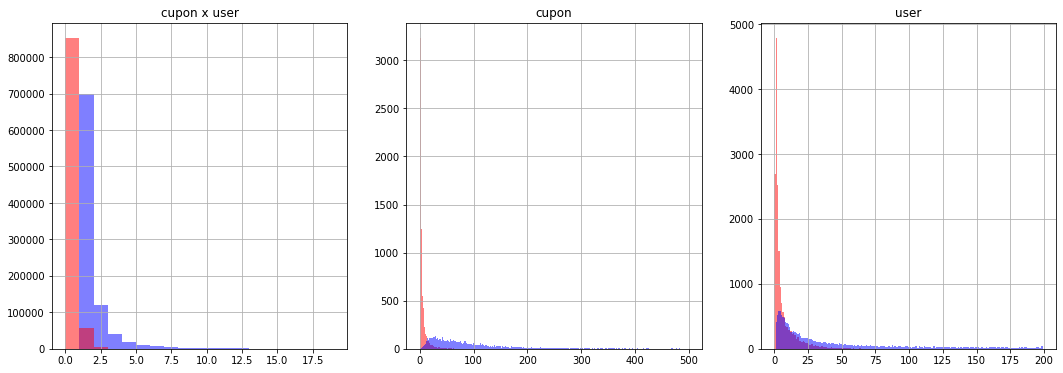

In [7]:
#
# this plots we used for the debug
#
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.title('cupon x user')
cu_prior.cu_p_b.hist(bins=range(20), color='b', alpha=0.5)
cu_prior.cu_p_a.hist(bins=range(20), color='r', alpha=0.5)

plt.subplot(1, 3, 2)
plt.title('cupon')
c_prior.c_p_a.hist(bins=range(500), color='r', alpha=0.5)
c_prior.c_p_b.hist(bins=range(500), color='b', alpha=0.5)

plt.subplot(1, 3, 3)
plt.title('user')
u_prior.u_p_a.hist(bins=range(200), color='r', alpha=0.5)
u_prior.u_p_b.hist(bins=range(200), color='b', alpha=0.5)


Here I had some idea to combine priors and observations manually and predict probability using approach from the first question. Its not really work, and best what I got is base line. I think there is some bug, or my misunderstanding. Any case, this approach, even it will work, doo not takes into consideration all avilable data, like sex or ganre, etc. But these data can be important when we met user/coupon first time. So I turned to use some classsifier. 

In [8]:

p_fallback = df_train['flag'].mean()

def beta_mean(a, b):
    m = a/(a+b)
    m[a + b == 0] = p_fallback
    return m

def beta_mode(a, b):
    m = (a - 1)/(a + b - 2)
    m[(a == 1) & (b == 1)] = p_fallback
    m[(a <= 1) & (b > 1)] = 0
    m[(a > 1) & (b <= 1)] = 1
    return m

df_work = df_train
y_gt = df_work['flag']

df_work = df_work.set_index(['cid']).join(c_prior).reset_index() \
                 .set_index(['uid']).join(u_prior).reset_index() \
                 .set_index(['cid', 'uid']).join(cu_prior).reset_index() 

df_work['prior_a'] = df_work['cu_p_a']
df_work['prior_b'] = df_work['cu_p_b']
df_work['a'] = df_work['cu_a']
df_work['b'] = df_work['cu_b']

total_cases = df_work.shape[0]

CU_MIN = 5
cu_fail_mask = (df_work.cu_p_n < CU_MIN) | df_work.cu_p_n.isna()
df_work.loc[cu_fail_mask, 'prior_a'] = df_work['c_p_a']
df_work.loc[cu_fail_mask, 'prior_b'] = df_work['c_p_b']
df_work.loc[cu_fail_mask, 'a'] = df_work['c_a']
df_work.loc[cu_fail_mask, 'b'] = df_work['c_b']
cu_cases = total_cases - cu_fail_mask.sum()

C_MIN = 25
c_fail_mask = cu_fail_mask & ((df_work.c_p_n < C_MIN) | df_work.c_p_n.isna())
df_work.loc[c_fail_mask, 'prior_a'] = df_work['u_p_a']
df_work.loc[c_fail_mask, 'prior_b'] = df_work['u_p_b']
df_work.loc[c_fail_mask, 'a'] = df_work['u_a']
df_work.loc[c_fail_mask, 'b'] = df_work['u_a']
c_cases = total_cases - c_fail_mask.sum()

U_MIN = 25
u_fail_mask = c_fail_mask & ((df_work.u_p_n < U_MIN) | df_work.u_p_n.isna())
df_work.loc[u_fail_mask, 'prior_a'] = df_train.flag.sum()
df_work.loc[u_fail_mask, 'prior_b'] = df_train.flag.shape[0] - df_train.flag.sum()
df_work.loc[u_fail_mask, 'a'] = 0
df_work.loc[u_fail_mask, 'b'] = 0
u_cases = total_cases - u_fail_mask.sum()

y_pred = beta_mode(df_work.prior_a + df_work.a, df_work.prior_b + df_work.b)
score = log_loss(y_gt, y_pred)
print('score:  %.2f' % (score * 100))


score:  46.74


In [9]:
#
# Test base line
#
y_gt = df_train.flag
y_pred = y_gt*0 + df_train.flag.mean()
score = log_loss(y_gt, y_pred)
print('base line score:  %.2f' % (score * 100))

base line score:  19.67


In [27]:
#
# construct features
#
numerical_column_0 = ['age', 'rate', 'c_price', 'd_price']
numerical_column_1 = [ 'c_a', 'c_b', 'u_a', 'u_b',  'cu_a', 'cu_b']
numerical_column_c = ['c_p_b', 'c_p_a']
numerical_column_u = ['u_p_b', 'u_p_a']

categorical_columns = ['sex', 'ganre']

all_columns = numerical_column_0 + \
              numerical_column_1 + \
              numerical_column_c + \
              numerical_column_u + \
              categorical_columns


def join_priors(df_set):
    return df_set.set_index(['cid']).join(c_prior).reset_index() \
                 .set_index(['uid']).join(u_prior).reset_index() \
                 .set_index(['cid', 'uid']).join(cu_prior).reset_index() 

data_train = join_priors(df_train)
data_valid = join_priors(df_valid)
data_tests = join_priors(df_tests)

In [28]:
from sklearn.preprocessing import Normalizer, StandardScaler, FunctionTransformer

feature_builder = make_column_transformer(
    (StandardScaler(), numerical_column_0),
    (StandardScaler(), numerical_column_1),
    (StandardScaler(), numerical_column_c),
    (StandardScaler(), numerical_column_u),
    (OneHotEncoder(handle_unknown='ignore'), categorical_columns)
)

feature_builder.fit(data_train)

x_train = feature_builder.transform(data_train)
y_train = data_train['flag']

x_valid = feature_builder.transform(data_valid)
y_valid = data_valid['flag']

x_tests = feature_builder.transform(data_tests)
y_tests = data_tests['flag']

In [39]:
class PartialClassifier:    
    """
      excludes features when they NaN. 
      Need to train model without coupon/user informarion.
      Will use it when will meet coupon/user thet not present in training set.
    """
    def __init__(self, dims, disabled_columns, hidden_layer_sizes, **kwargs):
        self.model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, **kwargs)
        self.cols = np.zeros(dims, dtype=bool)
        self.cols[np.where([(col in disabled_columns) for col in all_columns])] = True
        
    def fit(self, X, y):        
        self.model.fit(X[:, self.cols == False], y)
        return self
    
    def predict_partial(self, X):
        data = X[:, self.cols == False]
        mask = np.isnan(data).any(axis=1) == False
        pred = self.model.predict_proba(data[mask, :])
        y_pred = np.zeros(X.shape[0])*np.nan
        y_pred[mask] = pred[:, 1]
        return y_pred, mask
    
class CompositeClassifier:
    """
       Combine classifiers. Use one of 4: user/coupon/user+coupon/nothing
       depend on which history available from training set.
       
    """
    def __init__(self, dims, hidden_layer_sizes, **kwargs):
        self.all = PartialClassifier(dims, [], hidden_layer_sizes=hidden_layer_sizes, **kwargs)
        self.no_c = PartialClassifier(dims, numerical_column_c, hidden_layer_sizes, **kwargs)
        self.no_u = PartialClassifier(dims, numerical_column_u, hidden_layer_sizes, **kwargs)
        self.no_cu = PartialClassifier(dims, numerical_column_c + numerical_column_u, hidden_layer_sizes, **kwargs)
        
    def fit(self, X, y):
        self.all.fit(X, y)
        self.no_c.fit(X, y)
        self.no_u.fit(X, y)
        self.no_cu.fit(X, y)
        return self
    
    def predict_proba(self, X, y_gt=None):
        y_all,   mask_all    = self.all.predict_partial(X)
        y_no_c,  mask_no_c   = self.no_c.predict_partial(X)
        y_no_u,  mask_no_u  = self.no_u.predict_partial(X)
        y_no_cu, mask_no_cu = self.no_cu.predict_partial(X)
        
        y_result = np.zeros(y_all.shape)*np.nan
        y_result[mask_all] = y_all[mask_all]
        y_result[mask_no_c] = y_no_c[mask_no_c]        
        y_result[mask_no_u] = y_no_u[mask_no_u]        
        y_result[mask_no_cu] = y_no_cu[mask_no_cu]        
                
        if not (y_gt is None):
            print('all   ', log_loss(y_gt[mask_all], y_all[mask_all], labels=[False, True])), 
            print('no_c  ', log_loss(y_gt[mask_no_c], y_no_c[mask_no_c], labels=[False, True]))
            print('no_u  ', log_loss(y_gt[mask_no_u], y_no_u[mask_no_u], labels=[False, True])) 
            print('no_cu ', log_loss(y_gt[mask_no_cu], y_no_cu[mask_no_cu], labels=[False, True]))
            print('------------------------------------------')
            print('total ', log_loss(y_gt, y_result, labels=[False, True]))
        
        return y_result
        
    def score(self, X, y_gt):
        y_pred = self.predict_proba(X)
        return log_loss(y_gt, y_pred, labels=[False, True])



In [35]:
#
# Train.  
#
dims = x_train.shape[1]
model = CompositeClassifier(dims, hidden_layer_sizes=(30, 15, 10, 5), max_iter=100, tol=1e-4,  alpha=1e-12,
                            activation='relu', solver='adam', verbose=True, batch_size=4000)
modelSave = model.fit(x_train, y_train)


Iteration 1, loss = 0.26130934
Iteration 2, loss = 0.15656076
Iteration 3, loss = 0.13509266
Iteration 4, loss = 0.13008260
Iteration 5, loss = 0.12863149
Iteration 6, loss = 0.12752680
Iteration 7, loss = 0.12664288
Iteration 8, loss = 0.12599128
Iteration 9, loss = 0.12554145
Iteration 10, loss = 0.12506873
Iteration 11, loss = 0.12468981
Iteration 12, loss = 0.12434332
Iteration 13, loss = 0.12393758
Iteration 14, loss = 0.12359724
Iteration 15, loss = 0.12323396
Iteration 16, loss = 0.12284093
Iteration 17, loss = 0.12253744
Iteration 18, loss = 0.12210283
Iteration 19, loss = 0.12176527
Iteration 20, loss = 0.12133078
Iteration 21, loss = 0.12101875
Iteration 22, loss = 0.12060073
Iteration 23, loss = 0.12015145
Iteration 24, loss = 0.11983569
Iteration 25, loss = 0.11954852
Iteration 26, loss = 0.11925430
Iteration 27, loss = 0.11888594
Iteration 28, loss = 0.11867945
Iteration 29, loss = 0.11851286
Iteration 30, loss = 0.11820295
Iteration 31, loss = 0.11800691
Iteration 32, los

In [36]:
sets = [
    (x_train, y_train, 'train'),
    (x_valid, y_valid, 'valid'),
    (x_tests, y_tests, 'tests'),
]

for x,y,name in sets:
    y_pred = model.predict_proba(x)
    score = log_loss(y, y_pred, labels=[True, False])*100
    print(name, score)

train 13.124201410093367
valid 12.022287218025292
tests 12.842922902754117
